# Introduction
In this project we are going to analyze 'brain tumor dataset' T1 weighted images dataset from figshare,
<br>
apply some custom functions and Convolutional neural network model that predicts brain tumor type from given image.
#### This project inludes:
- Image data analysis
- Preprocessing data
- Creating neural network model
<br>

Highly reccomended to read the **data-description.txt** file to understand data organization.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import cv2 as cv
import os
from PIL import Image
import h5py
from skimage import exposure

# I Data preview
#### Step 1 - Image extraction
We're going to convert .mat files to .jpg files. This process basically had me to look at result folder manually to test the conversion by eye.
<br><br>
Preprocessing images:
1) Exposure
2) Contrast stretching
3) Value scaling

In [28]:
tf.random.set_seed(0)
mat_path = 'D:\\data-science\\brain-tumor-data\\mat'
data_path = 'D:\\data-science\\brain-tumor-data\\images'
label_names = ['meningioma', 'glioma', 'pituitary']
matrices = os.listdir(mat_path)

In [ ]:
for step in range(4):
    for i, mat in enumerate(matrices[:4]):
        with h5py.File(f"{mat_path}\\{mat}", 'r') as file:
            image = file['cjdata']['image']
            label = int(file['cjdata']['label'][0]) - 1

            image = np.array(image)
            
            # normalize img values where [min, max] = [0, 1] and multiply to [0, 255]
            image = np.array(image) / np.max(image)
            image *= 255
            image = image.astype(np.uint8)

            # 1 increase exposure
            if step == 1:
                image = exposure.equalize_hist(image)
                image *= 255
                image = image.astype(np.uint8)

            # 2 add contrast stretching
            if step == 2:
                image = exposure.equalize_hist(image)
                image = (image - (image.min())) / (image.max() - (image.min()))
                image *= 255
                image = np.array(image).astype(np.uint8)

            # 3 clean background from noise and limit amount of colors
            if step == 3:                
                image[image <= 30] = 0
                
                image //= 100
                image *= 100
                
                image = exposure.equalize_hist(image)
                image = (image - (image.min())) / (image.max() - (image.min()))
                image *= 255
                
                # divide array and then multiply it by same number [50, 70, 120] // 100, * 100 => [0, 0, 100]

                image = np.array(image).astype(np.uint8)

            img_values = Image.fromarray(image)

            file_name = label_names[label] + f"_{i}_{step}.png"
            img_values.save(data_path + '\\test\\' + file_name)

In [ ]:
for i, mat in enumerate(matrices):
    with h5py.File(f"{mat_path}\\{mat}", 'r') as file:
        image = file['cjdata']['image']
        label = int(file['cjdata']['label'][0]) - 1

        # taking off 'near black' values to reduce background noise
        image = np.array(image) / np.max(image)
        image *= 255
        image[image <= 50] = 0

        # function that fixes exposure
        image = exposure.equalize_hist(image)

        # add contrast stretching
        image = (image - (image.min())) / (image.max() - (image.min()))
        image *= 255
        
        image //= 100
        image *= 100

        image = np.array(image).astype(np.uint8)
        img_values = Image.fromarray(image)

        file_name = label_names[label] + f"_{i}.png"
        img_values.save(data_path + '\\' + label_names[label] + '\\' + file_name)
    # print(f"{(i + 1) / 3064 * 100} %")

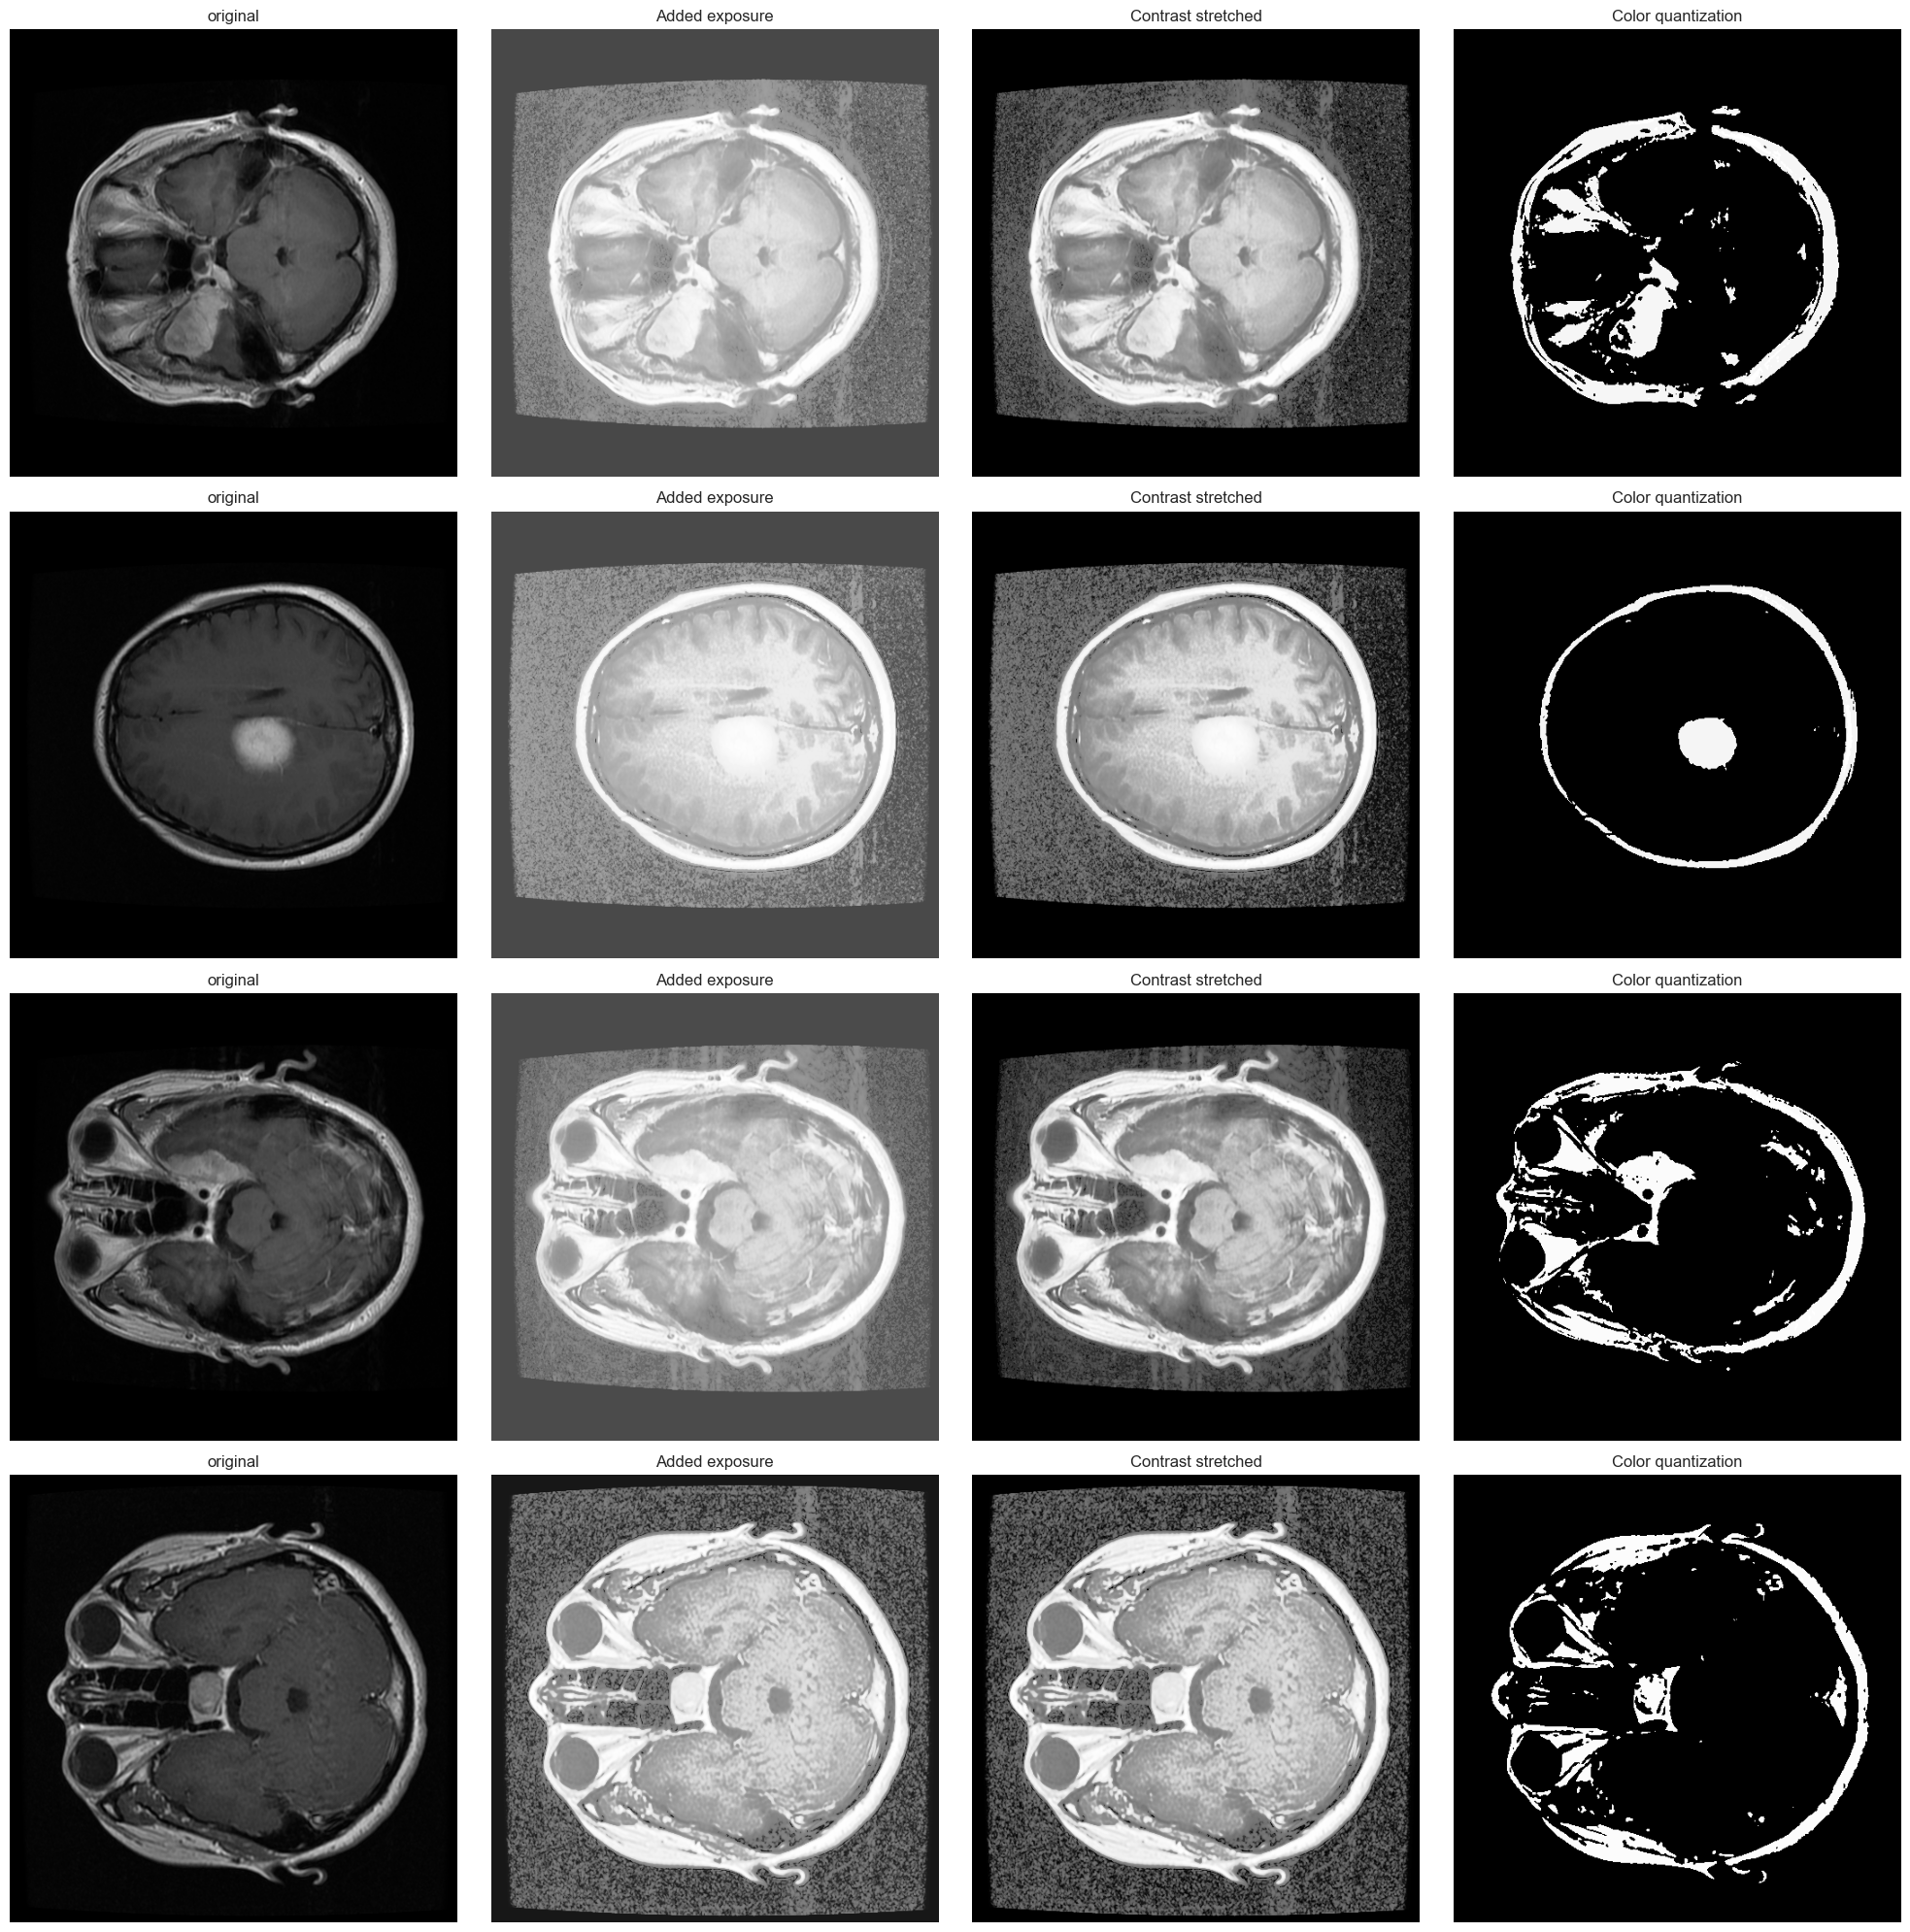

In [29]:
test_path = 'D:\\data-science\\brain-tumor-data\\test'
test_files = os.listdir(test_path)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

for i, file in enumerate(test_files):
    img = Image.open(test_path + '\\' + file)
    y, x = [int(x[0]) for x in file.split('_')[1:]]
    
    axes[y, x].imshow(img, cmap='grey', vmin=0, vmax=255)
    axes[y, x].set_axis_off()
    axes[y, 0].set_title('original')
    axes[y, 1].set_title('Added exposure')
    axes[y, 2].set_title('Contrast stretched')
    axes[y, 3].set_title('Color quantization')

plt.tight_layout()

In [30]:
data = tf.keras.utils.image_dataset_from_directory(data_path, batch_size=8, color_mode='grayscale', image_size=(256, 256))
label_names = data.class_names
print(f"Labels: {label_names}\n")

Found 3064 files belonging to 3 classes.
Labels: ['0', '1', '2']



In [31]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

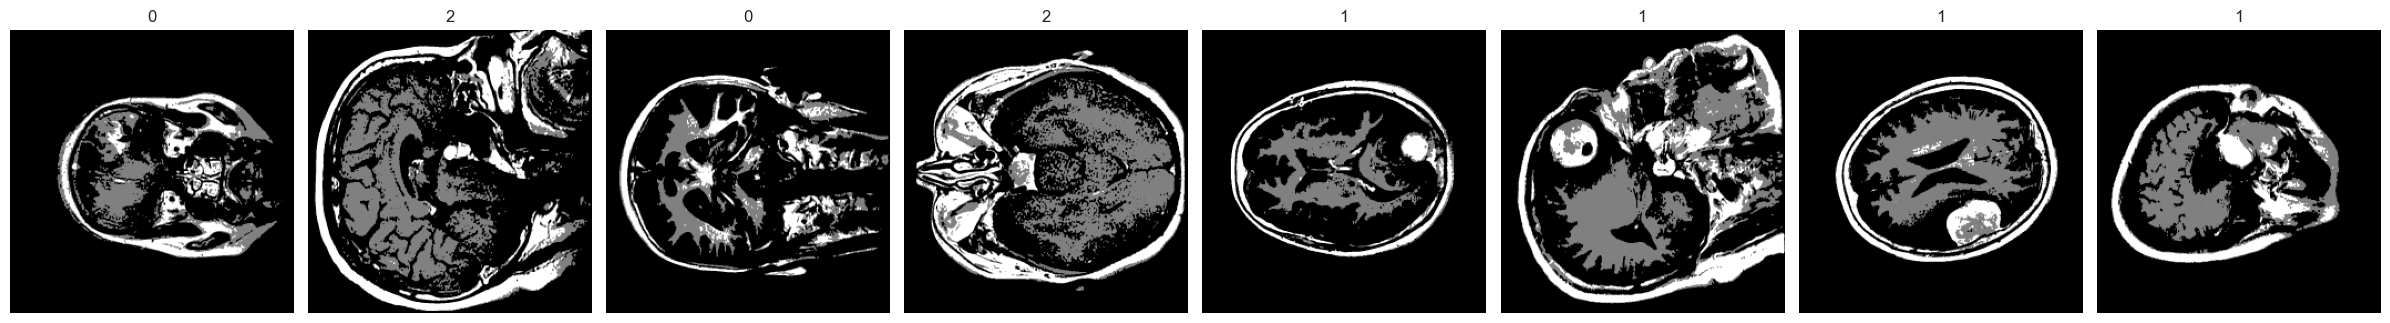

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(24, 6))
for i, img in enumerate(batch[0][:8]):
    class_name = label_names[batch[1][i]]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_name)
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()

         0: 1426
         1: 708
         2: 930


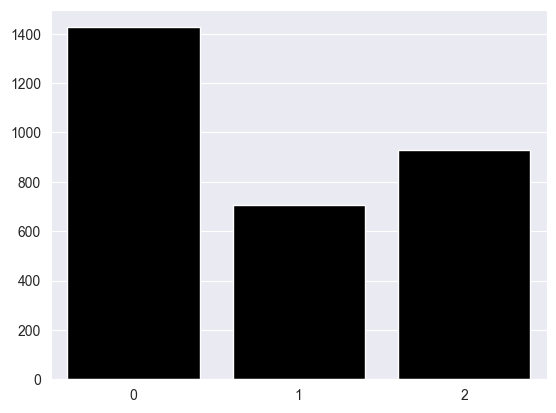

In [33]:
files_per_label = lambda x: os.listdir(data_path + '\\' + x)

labels_len = {label: len(files_per_label(label)) for label in label_names}

sb.barplot(data=labels_len, x=labels_len.keys(), y=labels_len.values(), color='Black')

for label in label_names:
    print(f"{label:>10}: {len(os.listdir(f"{data_path}\\{label}"))}")
    
plt.show()

*class weight = dataset length / (class length * amount of classes in dataset)*

In [51]:
class_weights = dict()

for i, label in enumerate(label_names):
    class_weights[i] = len(data) / labels_len[label] * len(labels_len)
    
print(class_weights)

{0: 0.805750350631136, 1: 1.6228813559322035, 2: 1.2354838709677418}


Our dataset contains 512px x 512px images and each pixel has 3 channels so basically each image contains **786 432** values,
<br>
by using *color_mode = 'grayscale'* we reduce it to **262 144**. Also keras resized our files to size of 256px x 256px so we end up with **65 536** values per image.
<br><br>
I tested downsampling by removing random files from glioma and pituitary folders. However it didn't help at all, it even dropped accuracy by almost 10%.

# II Feature scaling
Scaling our values from range (0, 255) to (0, 1) will help our optimization algorithm (Adam).
<br><br>
x = image values
<br> 
y = labels

In [35]:
print(batch[0].min(), batch[0].max(), sep='\n')

0.0
200.0


In [36]:
data = data.map(lambda x, y: (x/200, y))

In [37]:
iterator = data.as_numpy_iterator()
batch = iterator.next()

min_value = iterator.next()[0].min()
max_value = iterator.next()[0].max()

print(min_value, max_value, sep='\n')

0.0
1.0


Checking black/white balance in images. For selecting reference point on scale I used harmonic mean because it favortise lower values.
<br>
Every point on the plot is a single image, we can see that most of images hang around ratio of 0.19

          Mean: 0.5951886177062988
 Harmonic mean: 0.5944424867630005


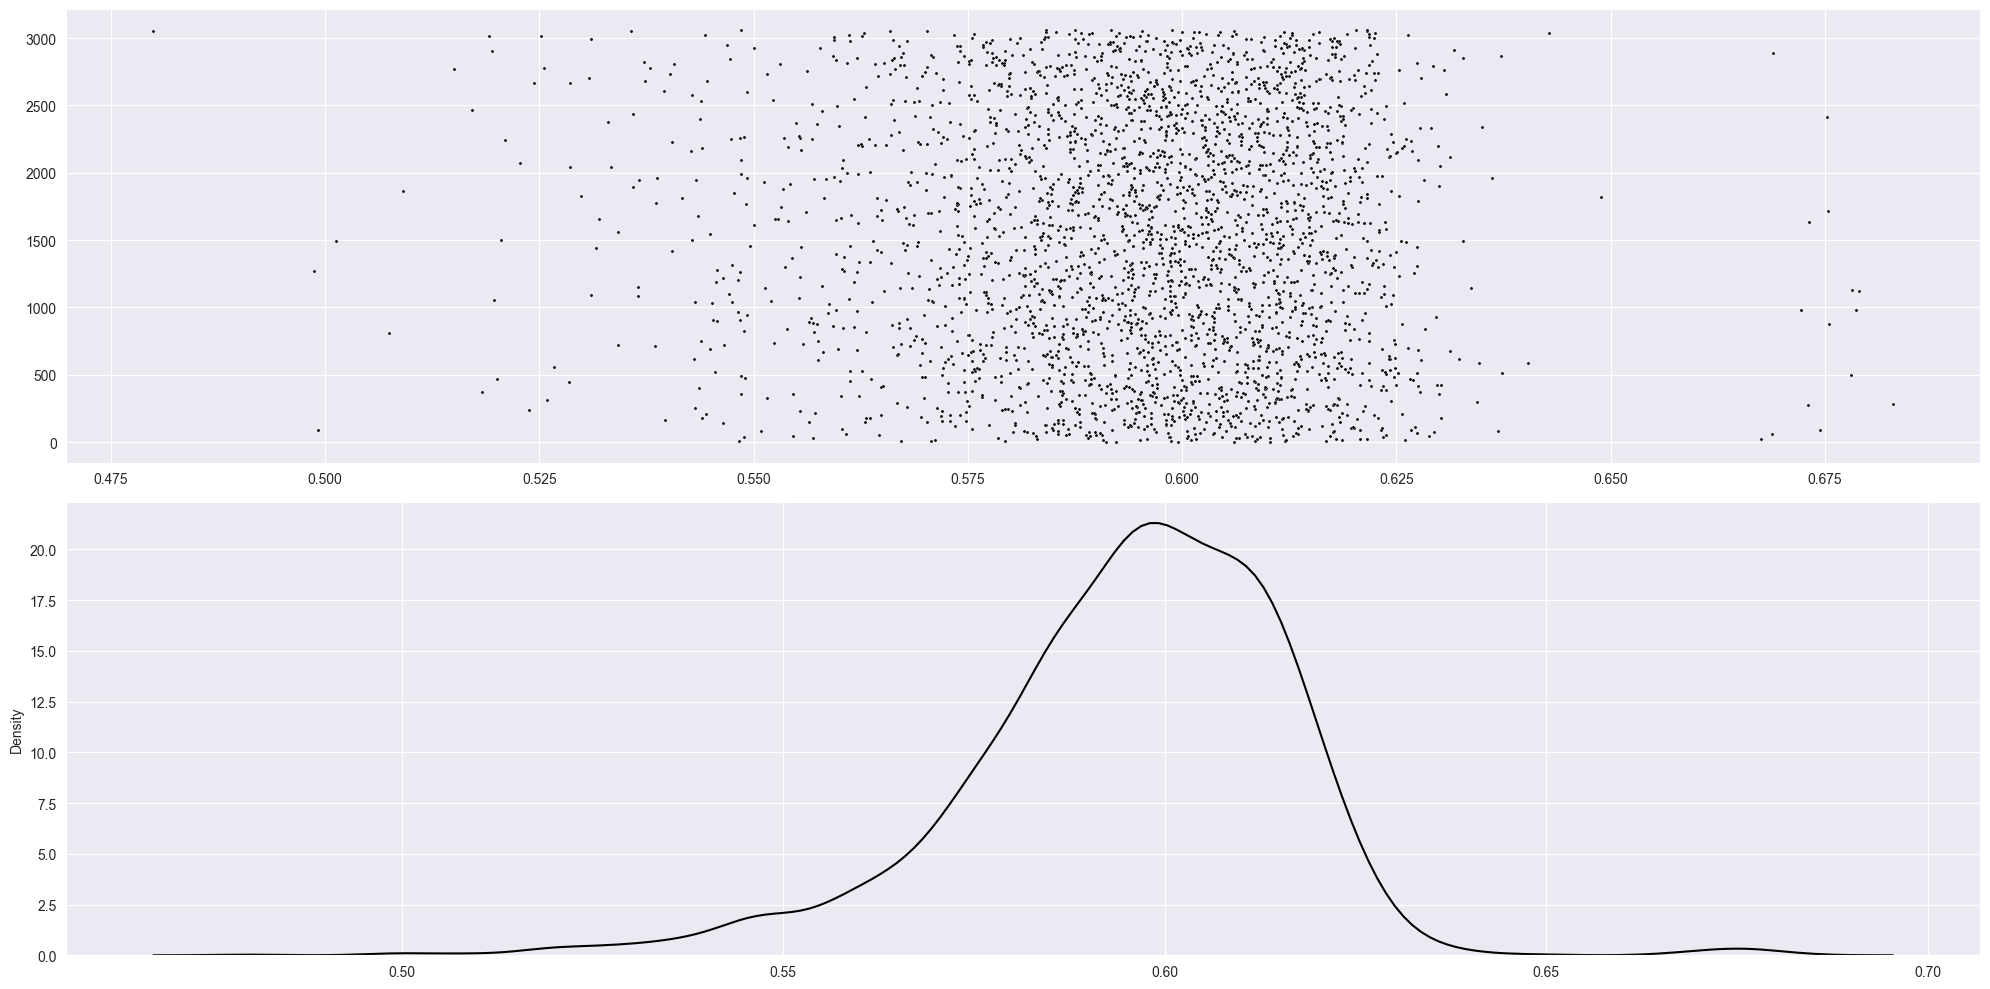

In [38]:
from scipy.stats.mstats import hmean

all_images = []
for images, label in data:
    all_images.append(images.numpy())

all_images = np.concatenate(all_images, axis=0)
# skipping value 0 because it's background and it will lower our mean
all_means = [x[x != 0].mean() for x in all_images]

print(f'{'Mean':>14}: {np.mean(all_means)}\n'
      f'{'Harmonic mean':>14}: {hmean(all_means)}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sb.scatterplot(y=[x for x in range(len(all_means))], x=all_means, color='black', s=5, ax=axes[0])
sb.kdeplot(x=all_means, color='black', ax=axes[1])
plt.tight_layout()

###### THIS FUNCTION WAS USED IN OLD DATASET WHERE MEAN VALUES WERE SPREAD MORE

In [ ]:
def scale_to_target(batch, target=0.5, multiplier=1):
    f"""
    This function scales image values inside given array to achieve mean value that equals target value.\n
    mean of array => target\n
    array - the array to be scaled\n
    target - value that we want our mean of given array to become\n
    multiplier - % of effect, 0.5 is basically mean of our array mean and target value
    """
    def scale_single_image(img):
        current_mean = tf.reduce_mean(img)
        new_mean = current_mean + (multiplier * (target - current_mean))
        scale_factor = new_mean / current_mean if current_mean != 0 else tf.cast(0, dtype=new_mean.dtype)
        return img * scale_factor

    scaled_batch = tf.map_fn(scale_single_image, batch)
    return scaled_batch

# III Creating CNN Model
- In short convolutional neural network base on layers that convolve input matrix (image) through filter matrices resulting filtered output.
<br>
- As input shape we apply values that corresponds to:
    - width = 256
    - height = 256
    - channel = 1 (we use grayscaled images).
<br>
- __*ReLU*__ activation function cleans our output from all unecesary negative values, replacing them with zeros that came from filter multiplication.
<br>
- Since our dataset contain 4 classes I applied __*softmax*__ activation to last step.

In [39]:
train_batch_size = round(len(data) * 0.7)
val_batch_size = round(len(data) * 0.2)
test_batch_size = round(len(data) * 0.1)

len(data) == train_batch_size + val_batch_size + test_batch_size

True

In [40]:
train = data.take(train_batch_size)
val = data.skip(train_batch_size).take(val_batch_size)
test = data.skip(train_batch_size + val_batch_size).take(test_batch_size)

print(
    f"train: {len(train)} batches\nval: {len(val)} batches\ntest: {len(test)} batches"
)

train: 268 batches
val: 77 batches
test: 38 batches


In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam

In [60]:
def create_model(num_filters = 16, kernel_size = 3, learning_rate = 0, regulate = 0):
    
    model = Sequential()
    
    model.add(Input(shape=(256, 256, 1)))
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters*2, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [61]:
model = create_model(learning_rate=0.0001)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,851 (14.10 MB)

 Trainable params: 3,696,851 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
n_epochs = 20
hist = model.fit(train, epochs=n_epochs, validation_data=val, class_weight=class_weights)

Epoch 1/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - accuracy: 0.5311 - loss: 1.0125 - val_accuracy: 0.7045 - val_loss: 0.6623
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.6875 - loss: 0.7206 - val_accuracy: 0.7873 - val_loss: 0.5089
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.7361 - loss: 0.6248 - val_accuracy: 0.8425 - val_loss: 0.4075
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.8149 - loss: 0.4714 - val_accuracy: 0.8669 - val_loss: 0.3428
Epoch 5/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.8464 - loss: 0.3989 - val_accuracy: 0.8685 - val_loss: 0.3168
Epoch 6/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.8761 - loss: 0.3398 - val_accuracy: 0.8377 - val_loss: 0.3592
Epoch 7/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.8895 - loss: 0.2824 - val_accuracy: 0.8896 - val_loss: 0.2570
Epoch 8/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9052 - loss: 0.2559 - 

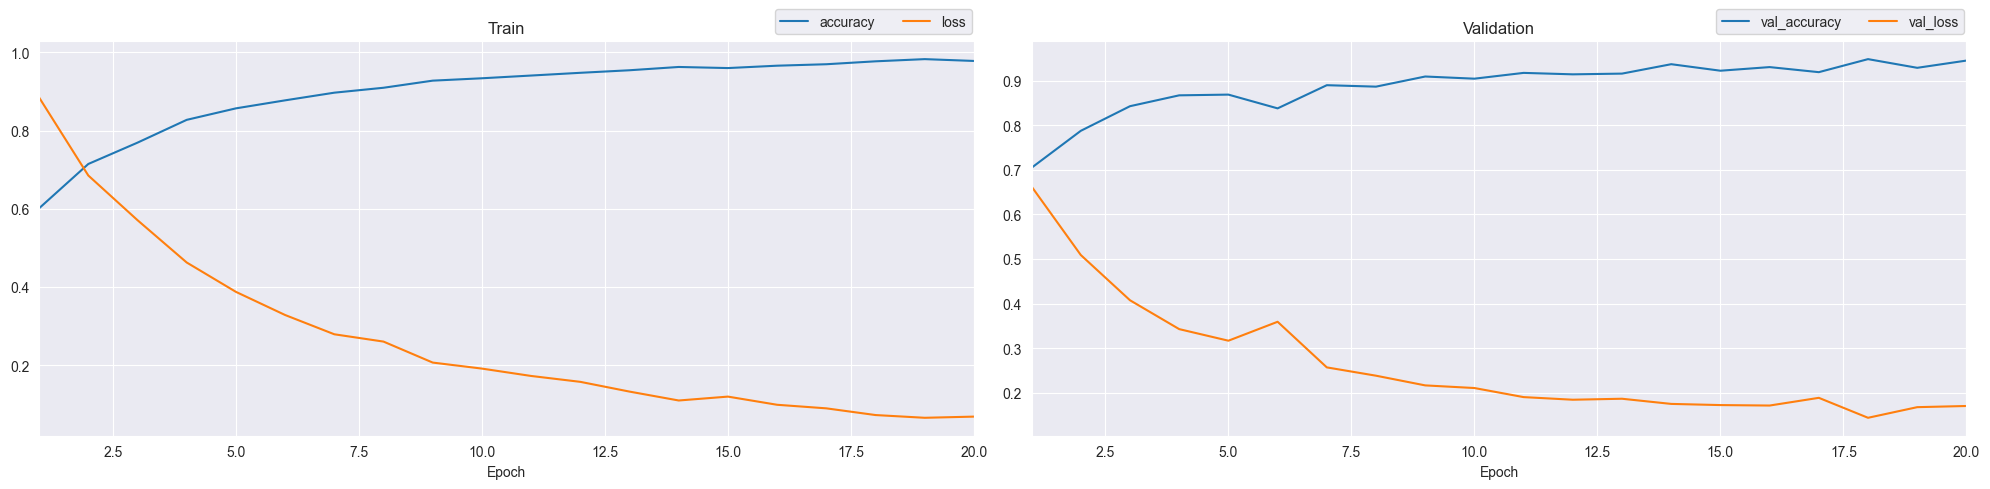

In [66]:
acc_labels = list(hist.history.keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
for i in range(4):
    fig = sb.lineplot(y=hist.history[acc_labels[i]], x=[x for x in range(1, n_epochs+1, 1)], label=acc_labels[i], ax=axes[i//2])
    axes[i//2].legend(loc='lower right', bbox_to_anchor=(1.005, 1), ncol=2)

axes[0].set_title('Train')
axes[0].set_xlabel('Epoch')
axes[0].set_xlim([1, n_epochs])

axes[1].set_title('Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_xlim([1, n_epochs])

plt.tight_layout()

In [67]:
y_true = []
y_pred = []

for batch_images, batch_labels in test:
    y_true_batch = batch_labels
    y_pred_batch = np.argmax(model.predict(batch_images, verbose=0), axis=1)

    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       144
           1       0.89      0.90      0.89        69
           2       0.98      0.98      0.98        91

    accuracy                           0.95       304
   macro avg       0.94      0.94      0.94       304
weighted avg       0.95      0.95      0.95       304



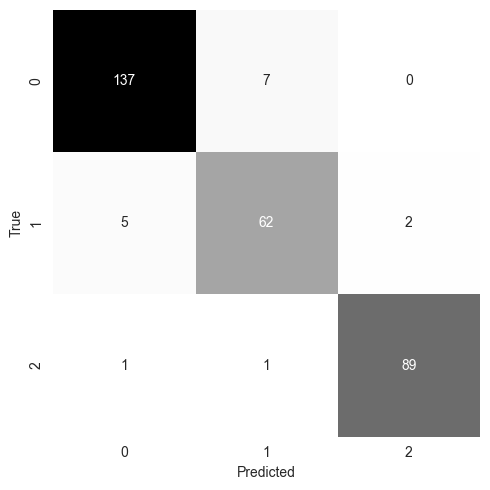

In [68]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_true, y_pred, target_names=label_names)
print(report)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig = plt.figure(figsize=(5, 5))
fig = sb.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

# IV Conclusion